## Imports

In [7]:
import sys
sys.path.append('../')
from Grating_and_parameters.SR_functions import D1_ND
from Grating_and_parameters.twobox import TwoBox
from Grating_and_parameters.parameters import Parameters
import numpy as np
import matplotlib.pyplot as plt

## Build grating

In [8]:
grating_type = "Ilic"

if grating_type=="Ilic":
    ## Ilic
    wavelength      = 1.5 #/ D1_ND(1.2/100)
    grating_pitch   = 1.8 / wavelength
    grating_depth   = 0.5 / wavelength
    box1_width      = 0.15 * grating_pitch
    box2_width      = 0.35 * grating_pitch
    box_centre_dist = 0.60 * grating_pitch
    box1_eps        = 3.5**2 
    box2_eps        = 3.5**2
    gaussian_width  = 2* 10   # 2.7180049942915896 * 10
    substrate_depth = 0.5 / wavelength
    substrate_eps   = 1.45**2
if grating_type=="Optimised":
    ## ~Second~ 'optimised grating
    grating_pitch   = 1.5384469388251338
    grating_depth   = 0.5580762361523982
    box1_width      = 0.10227122552871484
    box2_width      = 0.07605954942866577
    box_centre_dist = 0.2669020979549422
    box1_eps        = 9.614975107945112
    box2_eps        = 9.382304398409568
    gaussian_width  = 33.916288616522735
    substrate_depth = 0.17299998450776535
    substrate_eps   = 9.423032644325023
if grating_type=="First":
    grating_pitch       = 1.2269811605680625
    grating_depth       = 1.0708522822331097
    box1_width          = 0.14980809568967832
    box2_width          = 0.3138280436942734
    box_centre_dist     = 0.3563592721858686
    box1_eps            = 10.519396098839394
    box2_eps            = 2.1346426711459654
    gaussian_width      = 27.58894024158397
    substrate_depth     = 0.5382848081542992
    substrate_eps       = 9.270741779881561

wavelength      = 1.
angle           = 0.
Nx              = 100
numG            = 25
Qabs            = np.inf

grating = TwoBox(grating_pitch, grating_depth, box1_width, box2_width, box_centre_dist, box1_eps, box2_eps, 
                 gaussian_width, substrate_depth, substrate_eps,
                 wavelength, angle, Nx, numG, Qabs)

## Structure

In [ ]:
_, _, p_fig, p_ax = grating.show_permittivity(show_analytic_box=True)

## Gather data over wavelength (velocity) range

In [9]:
I, L, m, c = Parameters()

final_speed = 18.   
num_points = 600
wavelength_range = np.linspace(1, 1/D1_ND(final_speed/100), num_points)

extra = np.linspace(1/D1_ND(14.25/100), 1/D1_ND(14.75/100), 200)
wavelength_range = np.sort( np.append(wavelength_range,extra) )
num_points = len(wavelength_range)

from numpy.linalg import norm as norm

####################
## Build arrays

## Q arrays
Q1 = np.zeros(num_points)
Q2 = np.zeros(num_points)

## Restoring arrays
kyy = np.zeros(num_points)
kyphi = np.zeros(num_points)
kphiy = np.zeros(num_points)
kphiphi = np.zeros(num_points)

## Damping arrays
muyy = np.zeros(num_points)
muyphi = np.zeros(num_points)
muphiy = np.zeros(num_points)
muphiphi = np.zeros(num_points)

## Eigenvalue arrays
real1 = np.zeros(num_points)
real2 = np.zeros(num_points)
real3 = np.zeros(num_points)
real4 = np.zeros(num_points)
imag1 = np.zeros(num_points)
imag2 = np.zeros(num_points)
imag3 = np.zeros(num_points)
imag4 = np.zeros(num_points)

EIG = 0j*np.zeros( (num_points, 4) )
VEC = 0j*np.zeros( (num_points, 4, 4) )

vec1_mod = np.zeros( (4,num_points) )
vec2_mod = np.zeros( (4,num_points) )
vec3_mod = np.zeros( (4,num_points) )
vec4_mod = np.zeros( (4,num_points) )

## Calculate data
for i in range(len(wavelength_range)):
    wavelength = wavelength_range[i]
    Qs_array, rest_array, damp_array, real_array, imag_array, vec_array = grating.Linear_info_new(wavelength, I)
    ## Save to arrays
    Q1[i] = Qs_array[0];        Q2[i] = Qs_array[1]
    kyy[i] = rest_array[0];     kyphi[i] = rest_array[1];       kphiy[i] = rest_array[2];       kphiphi[i] = rest_array[3]
    muyy[i] = damp_array[0];    muyphi[i] = damp_array[1];      muphiy[i] = damp_array[2];      muphiphi[i] = damp_array[3]
    real1[i] = real_array[0];   real2[i] = real_array[1];       real3[i] = real_array[2];       real4[i] = real_array[3]
    imag1[i] = imag_array[0];   imag2[i] = imag_array[1];       imag3[i] = imag_array[2];       imag4[i] = imag_array[3]

    EIG[i] = real_array + 1j * imag_array
    VEC[i] = vec_array

    ## Extract (normalised) components of eigenvectors
    vec1, vec2, vec3, vec4 = vec_array
    vec1_mod[:,i] = np.abs(vec1)/norm(vec1)
    vec2_mod[:,i] = np.abs(vec2)/norm(vec2)
    vec3_mod[:,i] = np.abs(vec3)/norm(vec3)
    vec4_mod[:,i] = np.abs(vec4)/norm(vec4)

wavelength_minmax = [1, 1/D1_ND(final_speed/100)]

## Convert wavelength to velocity
v = np.zeros(num_points)
for i in range(num_points):
    D = 1/wavelength_range[i]
    v[i] = (1-D**2)/(1+D**2)
v = v*100
vlim = [0,final_speed]


## Sort $\mathfrak{Re}(\xi)$ and $\mathfrak{Im}(\xi)$ for plotting

In [ ]:
## Sort real and imaginary eigenvalues 
## (just for plotting - real[i] and imag[i] will not necessarily coincide)
sorted_eigenvalues_array = np.zeros_like(EIG, dtype=np.complex128)
sorted_real_array = np.zeros_like(EIG,dtype=np.float64)
sorted_imag_array = np.zeros_like(EIG,dtype=np.float64)
sorted_eigenvectors_array = np.zeros_like(VEC, dtype=np.complex128)
for i in range(num_points):
    sort_indices_real = np.argsort(np.real(EIG[i]))  # Get sorting order based on real
    sort_indices_imag = np.argsort(np.imag(EIG[i]))  # Get sorting order based on real

    sorted_real_array[i] = np.real(EIG)[i][sort_indices_real]
    sorted_imag_array[i] = np.imag(EIG)[i][sort_indices_imag]

    sorted_eigenvectors_array[i] = VEC[i][:, sort_indices_imag]  # Sort corresponding eigenvectors

## For plotting
real1_sort = sorted_real_array[:,0]
real2_sort = sorted_real_array[:,1]
real3_sort = sorted_real_array[:,2]
real4_sort = sorted_real_array[:,3]

imag1_sort = sorted_imag_array[:,0]
imag2_sort = sorted_imag_array[:,1]
imag3_sort = sorted_imag_array[:,2]
imag4_sort = sorted_imag_array[:,3]


## Plot eigenvalues $\mathfrak{Re}(\xi)$ and $\mathfrak{Im}(\xi)$ (for $\beta_f=20\%)$

In [11]:
### Imports ### 
from matplotlib.ticker import Locator
class MinorSymLogLocator(Locator):
    """
    Dynamically find minor tick positions based on the positions of
    major ticks for a symlog scaling.
    """
    def __init__(self, linthresh):
        """
        Ticks will be placed between the major ticks.
        The placement is linear for x between -linthresh and linthresh,
        otherwise its logarithmically
        """
        self.linthresh = linthresh

    def __call__(self):
        'Return the locations of the ticks'
        majorlocs = self.axis.get_majorticklocs()

        # iterate through minor locs
        minorlocs = []

        # handle the lowest part
        for i in range(1, len(majorlocs)):
            majorstep = majorlocs[i] - majorlocs[i-1]
            if abs(majorlocs[i-1] + majorstep/2) < self.linthresh:
                ndivs = 10
            else:
                ndivs = 9
            minorstep = majorstep / ndivs
            locs = np.arange(majorlocs[i-1], majorlocs[i], minorstep)[1:]
            minorlocs.extend(locs)

        return self.raise_if_exceeds(np.array(minorlocs))

    def tick_values(self, vmin, vmax):
        raise NotImplementedError('Cannot get tick locations for a '
                                  '%s type.' % type(self))
import matplotlib
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath, physics, amsfonts, siunitx}')

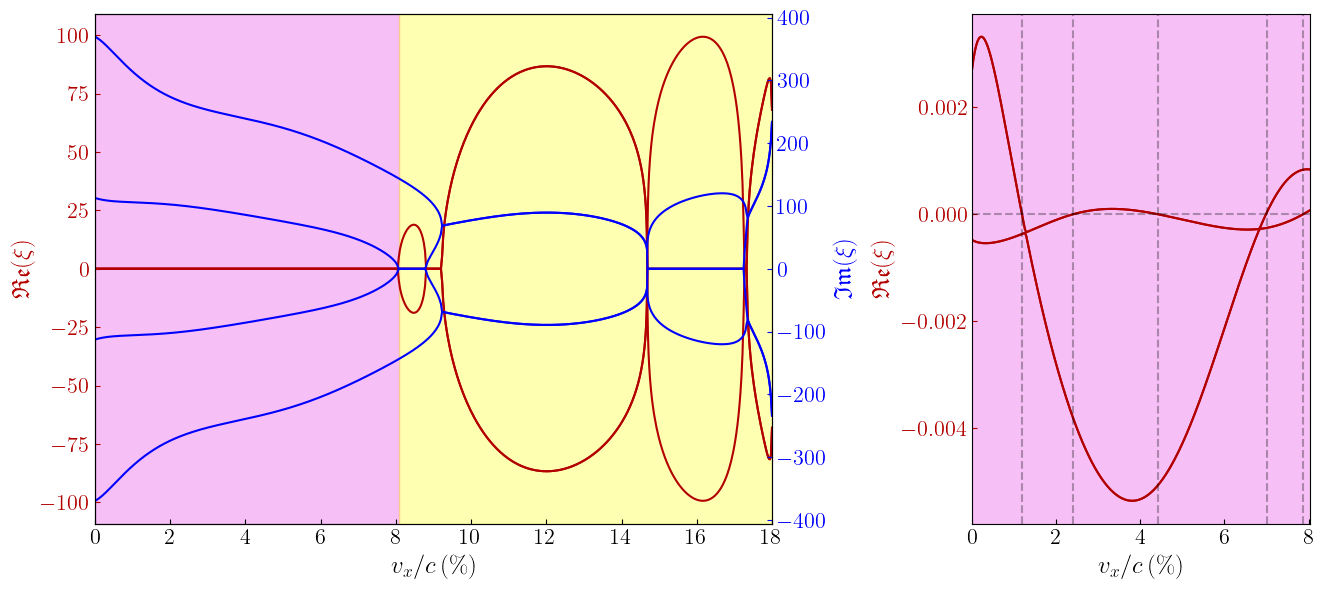

In [12]:
colorReal=(0.7, 0, 0)
colorImag= 'blue'
color_left="violet"
color_right = "yellow"
line_alpha = 0.3

v_split = 8.076055 # 7.984416791412602 (max of kyphi) # 7.216938074306444 # 9.168087275243453

### LEFT FIGURE ### 

## Figure
fig, axd = plt.subplot_mosaic(
    [ ["ax1","ax2"],    ],
    width_ratios=[2, 1],
    constrained_layout=True )
ax1 = axd["ax1"]

## Set-up
ax1b = ax1.twinx()
ax1.set_xlim(vlim) 
ax1b.set_xlim(vlim) 
ax1b.yaxis.tick_right()
ax1b.yaxis.set_label_position("right")

## Real part##
ax1.plot(v,real1_sort, '-', markersize=0.5, markerfacecolor=colorReal, fillstyle='full',  color=colorReal)
ax1.plot(v,real2_sort, '-', markersize=0.5, markerfacecolor=colorReal, fillstyle='full',  color=colorReal)
ax1.plot(v,real3_sort, '-', markersize=0.5, markerfacecolor=colorReal, fillstyle='full',  color=colorReal)
ax1.plot(v,real4_sort, '-', markersize=0.5, markerfacecolor=colorReal, fillstyle='full',  color=colorReal)
ylabel=r"$\mathfrak{Re}(\xi)$"
ax1_bounds = ax1.get_xlim()

## Imag part
ax1b.plot(v,imag1_sort, '-', markersize=0.5, markerfacecolor=colorImag, fillstyle='full',  color=colorImag)
ax1b.plot(v,imag2_sort, '-', markersize=0.5, markerfacecolor=colorImag, fillstyle='full',  color=colorImag)
ax1b.plot(v,imag3_sort, '-', markersize=0.5, markerfacecolor=colorImag, fillstyle='full',  color=colorImag)
ax1b.plot(v,imag4_sort, '-', markersize=0.5, markerfacecolor=colorImag, fillstyle='full',  color=colorImag)
ylabel2=r"$\mathfrak{Im}(\xi)$"

## Axis labels - real
ax1.tick_params(axis='both', which='both', direction='in')       # ticks inside box
ax1.tick_params(axis='y', color=colorReal, labelcolor=colorReal) # colored ticks
ax1.set_ylabel(ylabel=ylabel, color=colorReal)                   # colored y label
ax1.set(xlabel=r"$v_x/c \, (\%)$")

## Axis labels - imag
ax1b.tick_params(axis='both', which='both', direction='in') # ticks inside box
ax1b.tick_params(axis='y', color = colorImag, labelcolor=colorImag) # colored ticks
ax1b.set_ylabel(ylabel=ylabel2, color=colorImag)              # colored y label

ax1.axvspan(0, v_split, alpha=0.5, color=color_left)
ax1.axvspan(v_split, vlim[-1], alpha=0.3, color=color_right)

## Truncate
v_start = 0 ; v_end = v_split
index_trunc = (v>=v_start) & (v<=v_end)
v_trunc = v[ index_trunc ]
v_lim_trunc = [v_trunc[0], v_trunc[-1]]
real1_trunc = real1_sort[ index_trunc ]
real2_trunc = real2_sort[ index_trunc ]
real3_trunc = real3_sort[ index_trunc ]
real4_trunc = real4_sort[ index_trunc ]
imag1_trunc = imag1_sort[ index_trunc ]
imag2_trunc = imag2_sort[ index_trunc ]
imag3_trunc = imag3_sort[ index_trunc ]
imag4_trunc = imag4_sort[ index_trunc ]

### RIGHT FIGURE ###

## Plot
ax2a = axd["ax2"]
ax2a.set_xlim(v_lim_trunc) 


## Plot eigs vs wavelength ##
colorReal=(0.7, 0, 0)
ax2a.plot(v_trunc,real1_trunc, '-', markersize=0.5, markerfacecolor=colorReal, fillstyle='full',  color=colorReal)
ax2a.plot(v_trunc,real2_trunc, '-', markersize=0.5, markerfacecolor=colorReal, fillstyle='full',  color=colorReal)
ax2a.plot(v_trunc,real3_trunc, '-', markersize=0.5, markerfacecolor=colorReal, fillstyle='full',  color=colorReal)
ax2a.plot(v_trunc,real4_trunc, '-', markersize=0.5, markerfacecolor=colorReal, fillstyle='full',  color=colorReal)
ylabel=r"$\mathfrak{Re}(\xi)$"

# Axis labels
ax2a.tick_params(axis='both', which='both', direction='in')       # ticks inside box
ax2a.tick_params(axis='y', color=colorReal, labelcolor=colorReal) # colored ticks
ax2a.set_ylabel(ylabel=ylabel, color=colorReal)                   # colored y label
ax2a.set(xlabel=r"$v_x/c \, (\%)$")

ax2a.axvspan(0, v_split, alpha=0.5, color=color_left)
right_x_bounds = ax2a.get_xlim()
right_y_bounds = ax2a.get_ylim()
ax2a.axvspan(v_split, right_x_bounds[-1], alpha=0.2, color=color_right)
ax2a.hlines(0, right_x_bounds[0], right_x_bounds[-1], linestyles='--',color='black', alpha=line_alpha)

# Vertical lines
ax2a.vlines(v_trunc[36], right_y_bounds[0], right_y_bounds[-1], linestyles='--',color='black', alpha=line_alpha)
ax2a.vlines(v_trunc[73], right_y_bounds[0], right_y_bounds[-1], linestyles='--',color='black', alpha=line_alpha)
ax2a.vlines(v_trunc[136], right_y_bounds[0], right_y_bounds[-1], linestyles='--',color='black', alpha=line_alpha)
ax2a.vlines(v_trunc[218], right_y_bounds[0], right_y_bounds[-1], linestyles='--',color='black', alpha=line_alpha)
ax2a.vlines(v_trunc[246], right_y_bounds[0], right_y_bounds[-1], linestyles='--',color='black', alpha=line_alpha)
ax2a.set_ylim(right_y_bounds)

# Modify axes
cm_to_inch = 0.393701
fig_width = 40*cm_to_inch
fig_height = 17.6*cm_to_inch
fig.set_size_inches(fig_width/1.2, fig_height/1.2)

dpi = 600
# plt.savefig(rf"./Images/Ilic_eig_20_dpi{dpi}.jpeg",format="jpeg",dpi=dpi,bbox_inches='tight')
# plt.close(fig)

## Plots eigenvalues $\mathfrak{Re}(\xi)$ and $\mathfrak{Im}(\xi)$ (any $\beta_f$)

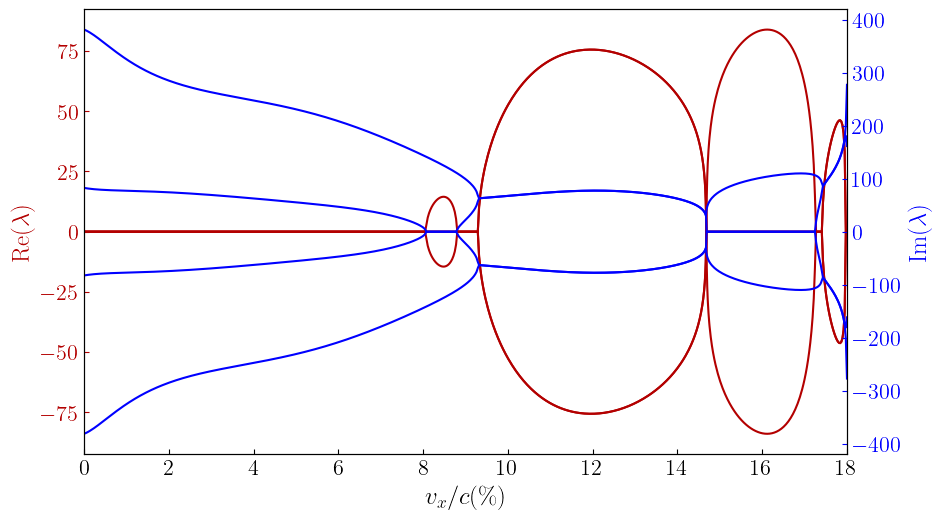

In [229]:
### PLOTTING ### 

fig, ax =plt.subplots(1,1)

# ax1.set_xlim(vlim)
ax2 = ax.twinx()
ax.set_xlim(vlim) 
ax2.set_xlim(vlim) 
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

## Plot eigs vs wavelength ##
colorReal=(0.7, 0, 0)
ax.plot(v,real1_sort, '-', markersize=0.5, markerfacecolor=colorReal, fillstyle='full',  color=colorReal)
ax.plot(v,real2_sort, '-', markersize=0.5, markerfacecolor=colorReal, fillstyle='full',  color=colorReal)
ax.plot(v,real3_sort, '-', markersize=0.5, markerfacecolor=colorReal, fillstyle='full',  color=colorReal)
ax.plot(v,real4_sort, '-', markersize=0.5, markerfacecolor=colorReal, fillstyle='full',  color=colorReal)
ylabel=rf"$\Re(\lambda)$"

colorImag= 'blue'
ax2.plot(v,imag1_sort, '-', markersize=0.5, markerfacecolor=colorImag, fillstyle='full',  color=colorImag)
ax2.plot(v,imag2_sort, '-', markersize=0.5, markerfacecolor=colorImag, fillstyle='full',  color=colorImag)
ax2.plot(v,imag3_sort, '-', markersize=0.5, markerfacecolor=colorImag, fillstyle='full',  color=colorImag)
ax2.plot(v,imag4_sort, '-', markersize=0.5, markerfacecolor=colorImag, fillstyle='full',  color=colorImag)
ylabel2=rf"$\Im(\lambda)$"


# Axis labels
ax.tick_params(axis='both', which='both', direction='in')       # ticks inside box
ax.tick_params(axis='y', color=colorReal, labelcolor=colorReal) # colored ticks
ax.set_ylabel(ylabel=ylabel, color=colorReal)                   # colored y label
ax.set(xlabel=r"$v_x/c (\%)$")

ax2.tick_params(axis='both', which='both', direction='in') # ticks inside box
ax2.tick_params(axis='y', color = colorImag, labelcolor=colorImag) # colored ticks
ax2.set_ylabel(ylabel=ylabel2, color=colorImag)              # colored y label
ax2.set(xlabel=r"$v_x/c (\%)$")

# Modify axes
cm_to_inch = 0.393701
fig_width = 30*cm_to_inch
fig_height = 17.6*cm_to_inch
fig.set_size_inches(fig_width/1.2, fig_height/1.2)

## Eigenvector evolution

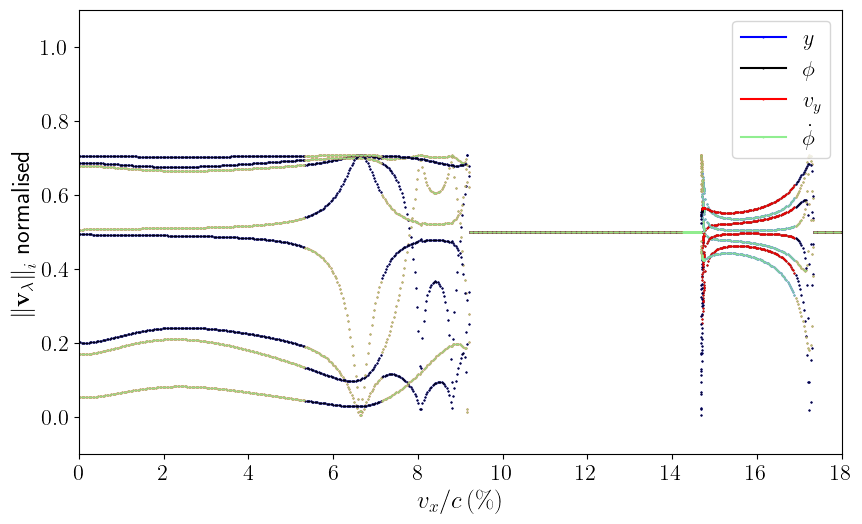

In [13]:
log_1 = False
marker = 'o'

## Colours
colorY="blue"
colorvY="red"  #cornflowerblue

colorphi="black"  #"royalblue"
colorvphi="lightgreen"  #coral

# Set up figure
fig, ax1 = plt.subplots(nrows=1, ncols=1,)
# fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
# dummy.axis('off')
# p = grating.grating_pitch
# ax1.set_xlim(np.array(wavelength_minmax)/p)
# ax2.set_xlim(np.array(wavelength_minmax)/p) 

from matplotlib.legend_handler import HandlerLine2D

## Plots
line1, = ax1.plot(v,vec1_mod[0], marker, markersize=0.5, label=r"$y$", color=colorY)
line2, = ax1.plot(v,vec1_mod[1], marker, markersize=0.5, label=r"$\phi$", color=colorphi)
line3, = ax1.plot(v,vec1_mod[2], marker, markersize=0.5, label=r"$v_y$", color=colorvY)
line4, = ax1.plot(v,vec1_mod[3], marker, markersize=0.5, label=r"$\dot{\phi}$", color=colorvphi)

ax1.plot(v,vec2_mod[0], marker, markersize=0.5, color=colorY)
ax1.plot(v,vec2_mod[1], marker, markersize=0.5, color=colorphi)
ax1.plot(v,vec2_mod[2], marker, markersize=0.5, color=colorvY)
ax1.plot(v,vec2_mod[3], marker, markersize=0.5, color=colorvphi)

ax1.plot(v,vec3_mod[0], marker, markersize=0.5, color=colorY)
ax1.plot(v,vec3_mod[1], marker, markersize=0.5, color=colorphi)
ax1.plot(v,vec3_mod[2], marker, markersize=0.5, color=colorvY)
ax1.plot(v,vec3_mod[3], marker, markersize=0.5, color=colorvphi)

ax1.plot(v,vec4_mod[0], marker, markersize=0.5, color=colorY)
ax1.plot(v,vec4_mod[1], marker, markersize=0.5, color=colorphi)
ax1.plot(v,vec4_mod[2], marker, markersize=0.5, color=colorvY)
ax1.plot(v,vec4_mod[3], marker, markersize=0.5, color=colorvphi)

ax1.set(xlim=vlim,ylim=(-0.1,1.1))
# ax1.set_xticks([0,1,2,2.7])
legend = ax1.legend(handler_map={
    line1: HandlerLine2D(numpoints=1),
    line2: HandlerLine2D(numpoints=1),
    line3: HandlerLine2D(numpoints=1) })
for legend_handle in legend.legend_handles:
    legend_handle.set_linestyle('-')

## Labels
ax1.set(xlabel=r"$v_x/c\, (\%)$", ylabel=r"$\norm{\vb{v}_{\lambda}}_i $ normalised")

## Logarithmic
if log_1:
    linthr = 0.1
    ax1.set_yscale("symlog", linthresh=linthr, linscale=0.4)
    ax1.yaxis.set_minor_locator(MinorSymLogLocator(linthr))

# Modify axes
cm_to_inch = 0.393701
fig_width = 30*cm_to_inch
fig_height = 17.6*cm_to_inch
fig.set_size_inches(fig_width/1.2, fig_height/1.2)

In [4]:
_, L,m ,c = Parameters()
I = 10e9
grating.wavelength = 1/ D1_ND(0/100)
real_here, imag_here, vec_here = grating.Eigs(I,m,c,"grad",False,True)
print(real_here[0]*1e3)
print(real_here[3]*1e3)
print(np.abs(vec_here[:,0]))
print(np.abs(vec_here[:,3]))

-0.028290180440029063
-0.4007031065267272
[3.01202077e-03 8.75829231e-04 9.60224340e-01 2.79212067e-01]
[1.28649059e-02 1.73207696e-04 9.99826614e-01 1.34612461e-02]


## Eigenvectors at v=0

In [167]:
_, L, m, c = Parameters()
I = 10e9
grating.wavelength = 1 / D1_ND(0/100)
real_v0, imag_v0, vec_v0 = grating.Eigs(I,m,c,"grad",False,True)
vec1 = vec_v0[:,0]
vec2 = vec_v0[:,1]
vec3 = vec_v0[:,2]
vec4 = vec_v0[:,3]

sum1 = np.real( vec1+vec2 )
sum = np.real( vec3+vec4 )
print(real_v0*1e3)
print(sum1[0], sum[0])
print(sum1[1], sum[1])
print(sum1[2], sum[2])
print(sum1[3], sum[3])
print()
print(sum[0])
print(sum[1])
print(sum[2])
print(sum[3])

[-0.02829018 -0.02829018 -0.40070311 -0.40070311]
5.345753475058606e-10 -1.3266038044024307e-07
3.061587515290477e-09 -8.337125305810491e-09
-1.9204486790123356 1.999653228985437
-0.558424134413175 0.02692249228938459

-1.3266038044024307e-07
-8.337125305810491e-09
1.999653228985437
0.02692249228938459


## Plot restoring terms

In [7]:
## Colors

colorX="black"   
colorvX="xkcd:pine green"

colorY="blue"
colorvY="dodgerblue"  #cornflowerblue

colorphi="red"  #"royalblue"
colorvphi="tomato"  #coral

colorRotate="darkgreen"
colorRotateRate="seagreen"

LabelSize=15

In [ ]:
################
# Restoring terms

fig,ax=plt.subplots(1,1,figsize=(7,5))

ax.plot(v,kyphi*1e-5,  label="$k^y_\phi$",color=colorvphi,linestyle="dotted")
ax.plot(v,kphiphi*1e-5,label="$k^\phi_\phi$",color=colorvphi)

ax.set_xlabel("$v_x/c$ ($\%$)",fontsize=LabelSize)
ax.set_ylabel("Restoring strength ($\partial/\partial \phi'$) $\\times 10^{-5}$",fontsize=LabelSize,color=colorvphi)
ax.tick_params(labelsize=15)
ax.tick_params(axis='y',labelcolor=colorvphi)


# ax.hlines(0,0,5,"k","dashed",alpha=0.2)
t=ax.get_ylim()
# ax.axhspan(0,t[1],color='black',alpha=0.2)

ax1=ax.twinx()

ax1.plot(v,kphiy*1e-3,  label="$k^\phi_y$",color=colorY,linestyle="dotted")
ax1.plot(v,kyy*1e-3,    label="$k^y_y$",color=colorY)

ax1.set_ylabel("Restoring strength ($\partial/\partial y'$)  $\\times 10^{-3}$",fontsize=LabelSize,color=colorY)
ax1.tick_params(labelsize=15)
ax1.tick_params(axis='y',labelcolor=colorY)


ax.set_ylim(t)
ax.set_xlim(vlim)

# ax.set_xticks([0,1,1.45,2,3,4,5])

handles, labels = ax.get_legend_handles_labels()
handles1, labels1 = ax1.get_legend_handles_labels()
order = [0,1]
order1=[1,0]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc=(0.5+0.2,0.5),fontsize=LabelSize)
ax1.legend([handles1[idx] for idx in order1],[labels1[idx] for idx in order1],loc=(0.5,0.5),fontsize=LabelSize)

fig.tight_layout()
# plt.savefig("Saved/Restoring300.jpeg",format="jpeg",dpi=300,bbox_inches='tight')
# plt.close()



## Damping terms

In [ ]:
##############
# Damping terms

fig,ax=plt.subplots(1,1,figsize=(7,5))


ax.plot(v,muyphi*1e2,  label="$\mu^y_\phi$",color=colorvphi,linestyle="dotted")
ax.plot(v,muphiphi*1e2,label="$\mu^\phi_\phi$",color=colorvphi)

ax.set_xlabel("$v_x/c$ ($\%$)",fontsize=LabelSize)
ax.set_ylabel("Damping strength ($\partial/\partial \phi'$) $\\times 10^{2}$",fontsize=LabelSize,color=colorvphi)
ax.tick_params(labelsize=15)
ax.tick_params(axis='y',labelcolor=colorvphi)

t=ax.get_ylim()
ax1=ax.twinx()

ax1.plot(v,muphiy*1e4,  label="$\mu^\phi_y$",color=colorY,linestyle="dotted")
ax1.plot(v,muyy*1e4,    label="$\mu^y_y$",color=colorY)

ax1.set_ylabel("Damping strength ($\partial/\partial y'$) $\\times 10^{4}$",fontsize=LabelSize,color=colorY)
ax1.tick_params(labelsize=15)
ax1.tick_params(axis='y',labelcolor=colorY)

# # Does not correspond to 1.28%
# ax.vlines(1.4507253626813408,t[0],0,color='k',linestyle='dashed',alpha=0.2)
# ax.hlines(0,0,1.4507253626813408,color='k',linestyle='dashed',alpha=0.2)

ax.set_ylim(t)
ax.set_xlim(vlim)

# ax.set_xticks([0,1,1.45,2,3,4,5])

handles, labels = ax.get_legend_handles_labels()
handles1, labels1 = ax1.get_legend_handles_labels()
order = [0,1]
order1=[1,0]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc=(0.5+0.2,0.5),fontsize=LabelSize)
ax1.legend([handles1[idx] for idx in order1],[labels1[idx] for idx in order1],loc=(0.5,0.5),fontsize=LabelSize)

fig.tight_layout()
# plt.savefig("Saved/Damping300.jpeg",format="jpeg",dpi=300,bbox_inches='tight')
# plt.close()


## Plot Jacobian terms over $v_x/c$

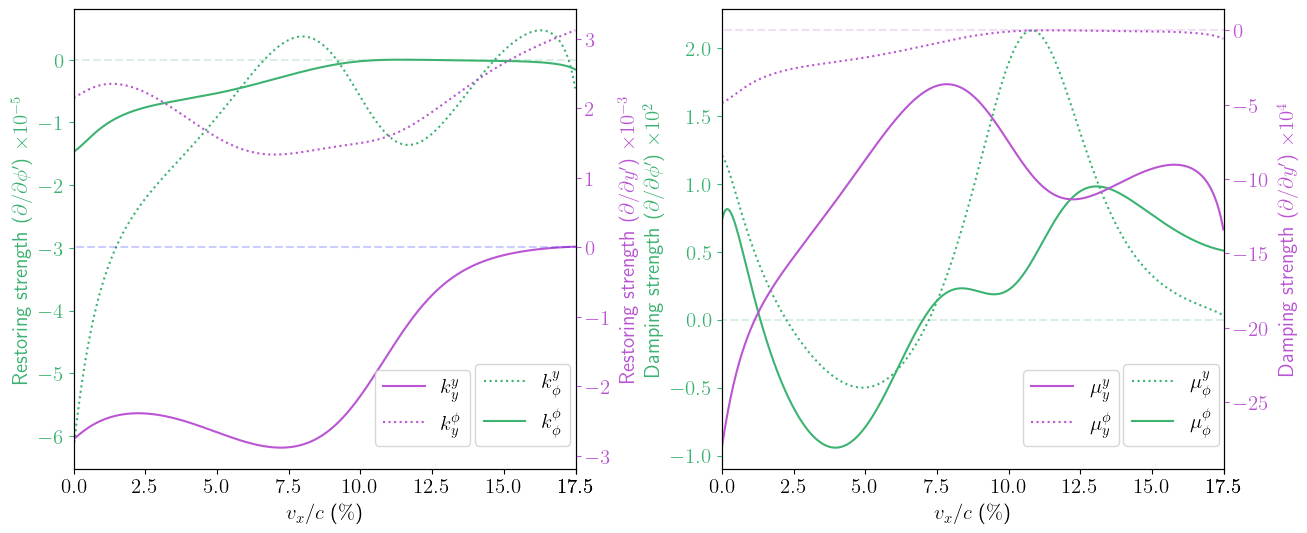

In [396]:
colorX="black"   
colorvX="xkcd:pine green"

colorY="blue"
colorvY= "mediumorchid" #dodgerblue"  #cornflowerblue

colorphi="red"  #"royalblue"
colorvphi= "mediumseagreen" #"tomato"  #coral

colorRotate="darkgreen"
colorRotateRate="seagreen"


## Truncate
v_start = 0; v_end = 17.5
v_index = (v>=v_start) & (v<=v_end)
v_trunc = v[ v_index ]
vlim_trunc = [v_trunc[0], v_trunc[-1]]
kyy_trunc       = kyy[ v_index ]
kyphi_trunc     = kyphi[ v_index ]
kphiy_trunc     = kphiy[ v_index ]
kphiphi_trunc   = kphiphi[ v_index ]
muyy_trunc      = muyy[ v_index ]
muyphi_trunc    = muyphi[ v_index ]
muphiy_trunc    = muphiy[ v_index ]
muphiphi_trunc  = muphiphi[ v_index ]

################
## Restoring terms

# phi derivatives
fig,(ax, ax2) =plt.subplots(1,2,figsize=(15,5))

ax.plot(v_trunc,kyphi_trunc*1e-5,  label="$k^y_\phi$",color=colorvphi,linestyle="dotted")
ax.plot(v_trunc,kphiphi_trunc*1e-5,label="$k^\phi_\phi$",color=colorvphi)

ax.set_xlabel("$v_x/c$ ($\%$)",fontsize=LabelSize)
ax.set_ylabel("Restoring strength ($\partial/\partial \phi'$) $\\times 10^{-5}$",fontsize=LabelSize,color=colorvphi)
ax.tick_params(labelsize=15)
ax.tick_params(axis='y',labelcolor=colorvphi, color=colorvphi)


t=ax.get_ylim()
X = ax.get_xlim()
ax.hlines(0,X[0],X[1],"k","dashed", color=colorvphi, alpha=0.2)
# ax.axhspan(0,t[0],t[1],'--',color=colorvphi,alpha=0.2)

# y derivatives
ax1=ax.twinx()
ax1.plot(v_trunc,kphiy_trunc*1e-3,  label="$k^\phi_y$",color=colorvY,linestyle="dotted")
ax1.plot(v_trunc,kyy_trunc*1e-3,    label="$k^y_y$",color=colorvY)

ax1.set_ylabel("Restoring strength ($\partial/\partial y'$)  $\\times 10^{-3}$",fontsize=LabelSize,color=colorvY)
ax1.tick_params(labelsize=15)
ax1.tick_params(axis='y',labelcolor=colorvY, color = colorvY)

X = ax.get_xlim()
ax1.hlines(0,X[0],X[1],"k","dashed", color=colorY, alpha=0.2)
ax.set_ylim(t)
ax.set_xlim(vlim_trunc)

# ax.set_xticks([0,1,1.45,2,3,4,5])

handles, labels = ax.get_legend_handles_labels()
handles1, labels1 = ax1.get_legend_handles_labels()
order = [0,1]
order1=[1,0]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc=(0.6+0.2,0.05),fontsize=LabelSize)
ax1.legend([handles1[idx] for idx in order1],[labels1[idx] for idx in order1],loc=(0.6,0.05),fontsize=LabelSize)

################
## Damping terms

# vy derivatives
ax2.plot(v_trunc,muyphi_trunc*1e2,  label="$\mu^y_\phi$",color=colorvphi,linestyle="dotted")
ax2.plot(v_trunc,muphiphi_trunc*1e2,label="$\mu^\phi_\phi$",color=colorvphi)
ax2.set_xlabel("$v_x/c$ ($\%$)",fontsize=LabelSize)
ax2.set_ylabel("Damping strength ($\partial/\partial \phi'$) $\\times 10^{2}$",fontsize=LabelSize,color=colorvphi)
ax2.tick_params(labelsize=15)
ax2.tick_params(axis='y',labelcolor=colorvphi, color=colorvphi)

t2=ax2.get_ylim()
X = ax2.get_xlim()
ax2.hlines(0,X[0],X[1],"k","dashed", color=colorvphi, alpha=0.2)

# vphi derivatvies
ax2b=ax2.twinx()
ax2b.plot(v_trunc,muphiy_trunc*1e4,  label="$\mu^\phi_y$",color=colorvY,linestyle="dotted")
ax2b.plot(v_trunc,muyy_trunc*1e4,    label="$\mu^y_y$",color=colorvY)

ax2b.set_ylabel("Damping strength ($\partial/\partial y'$) $\\times 10^{4}$",fontsize=LabelSize,color=colorvY)
ax2b.tick_params(labelsize=15)
ax2b.tick_params(axis='y',labelcolor=colorvY, color=colorvY)

X = ax2b.get_xlim()
ax2b.hlines(0,X[0],X[1],"k","dashed", color=colorvY, alpha=0.2)
ax2.set_ylim(t2)
ax2.set_xlim(vlim_trunc)

handles, labels = ax2.get_legend_handles_labels()
handles1, labels1 = ax2b.get_legend_handles_labels()
order = [0,1]
order1=[1,0]
ax2.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc=(0.6+0.2,0.05),fontsize=LabelSize)
ax2b.legend([handles1[idx] for idx in order1],[labels1[idx] for idx in order1],loc=(0.6,0.05),fontsize=LabelSize)

fig.tight_layout()

# Modify axes
cm_to_inch = 0.393701
fig_width = 40*cm_to_inch
fig_height = 17.6*cm_to_inch
fig.set_size_inches(fig_width/1.2, fig_height/1.2)

ax_x_ticks = np.append(ax.get_xticks(),   17.5)
ax2_x_ticks = np.append(ax2.get_xticks(), 17.5)
ax.set_xticks(ax_x_ticks)
ax2.set_xticks(ax2_x_ticks)

dpi = 300
# plt.savefig(rf"./Images/Jacobian_terms_20_dpi{dpi}.jpeg",format="jpeg",dpi=dpi,bbox_inches='tight')
# plt.close()

## Diffraction efficiencies $Q_{pr,j'}'(0,\lambda')$

Text(0.5, 0.98, "Efficiency factors at $\\delta'=0$")

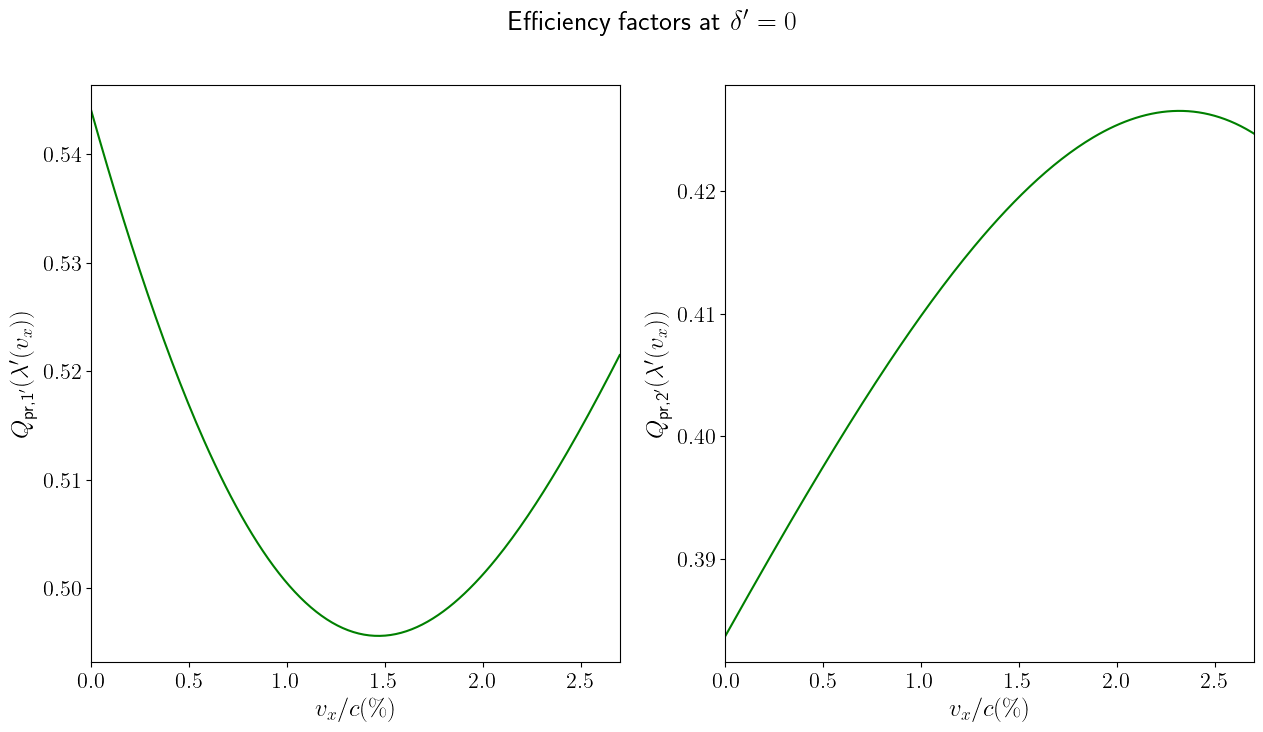

In [140]:
##############################
#### Plotting
cutoff = np.arcsin( 1 - wavelength / grating_pitch) * (180/np.pi)
cutoff2_test = 1 - 2* wavelength / grating_pitch
order_2 = False
if np.abs(cutoff2_test)<1:
    order_2 = True
    cutoff2 = np.arcsin(cutoff2_test) * (180/np.pi)

## Efficiency factors
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.plot(v, Q1,       color="green",    label="GRCWA")
ax2.plot(v, Q2,       color="green",    label="GRCWA")
ax1.set_xlim(vlim)
ax2.set_xlim(vlim)


ax1.set_xlabel("$v_x/c (\%)$")
ax1.set_ylabel("$Q_{\\text{pr,1}'} (\lambda'(v_x))$")
ax2.set_xlabel("$v_x/c (\%)$")
ax2.set_ylabel("$Q_{\\text{pr,2}'} (\lambda'(v_x))$")

fig.suptitle(rf"Efficiency factors at $\delta'=0$")

## Diffraction efficiencies $Q_{pr,j'}'(\delta',\lambda'=\lambda_0)$

In [173]:
wavelength = 1/D1_ND(16.869/100)
cutoff = np.arcsin( 1 - wavelength / grating_pitch) * (180/np.pi)
cutoff2_test = 1 - 2* wavelength / grating_pitch
order_2 = False
if np.abs(cutoff2_test)<1:
    order_2 = True
    cutoff2 = np.arcsin(cutoff2_test) * (180/np.pi)
print(np.tan( (np.pi/180)*cutoff)*100, cutoff2)
print(cutoff)

0.00029944544949335103 -89.80170502736777
0.0001715696045031559


Text(0.5, 0.98, "Efficiency factors at $\\lambda'=$ 1.19")

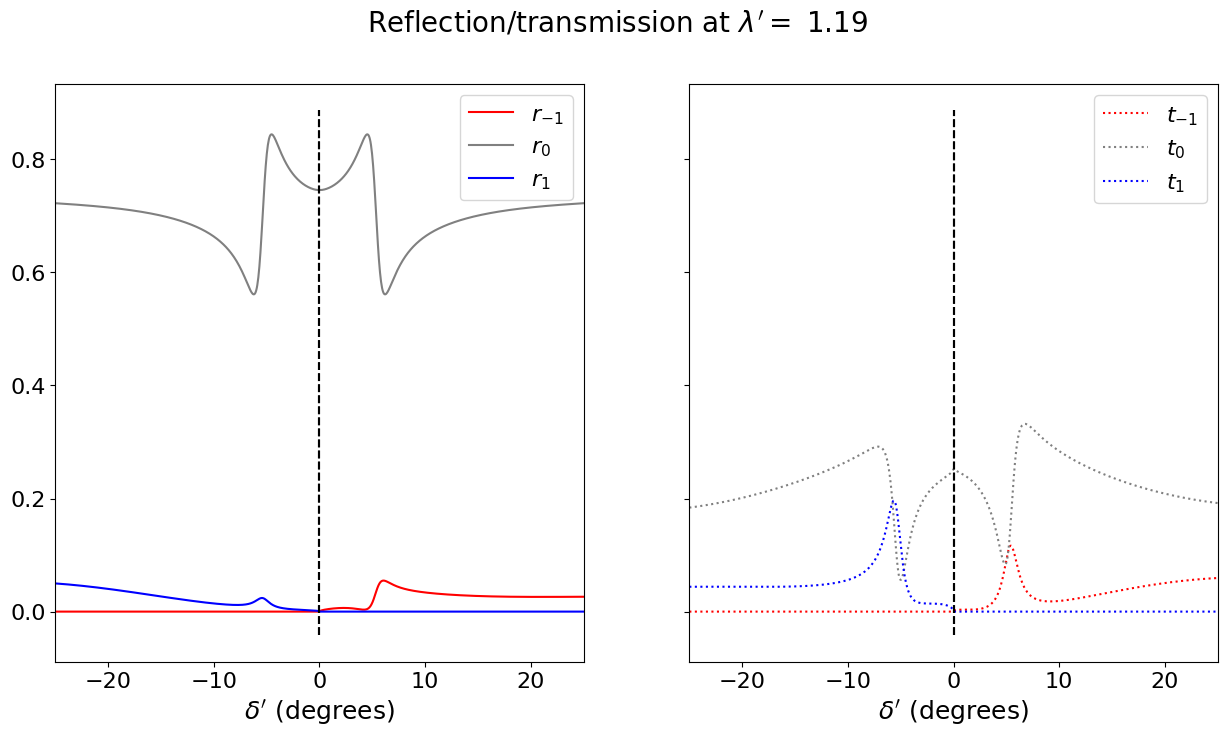

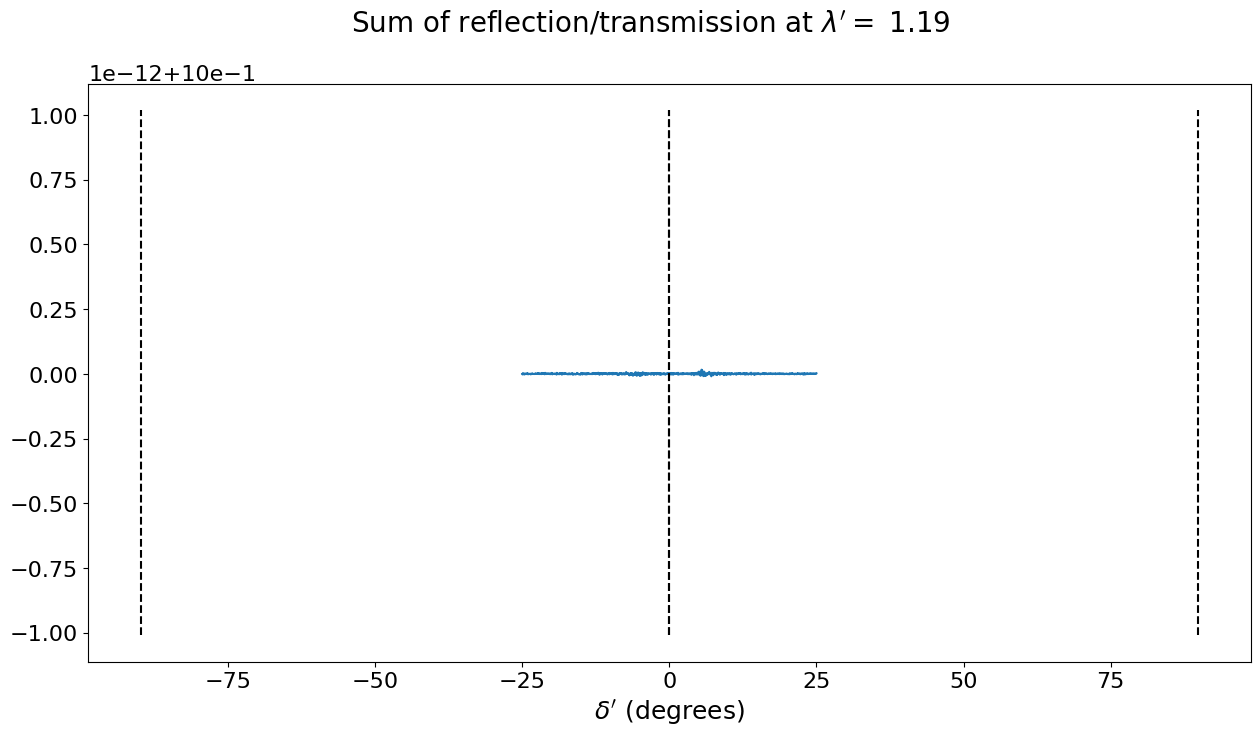

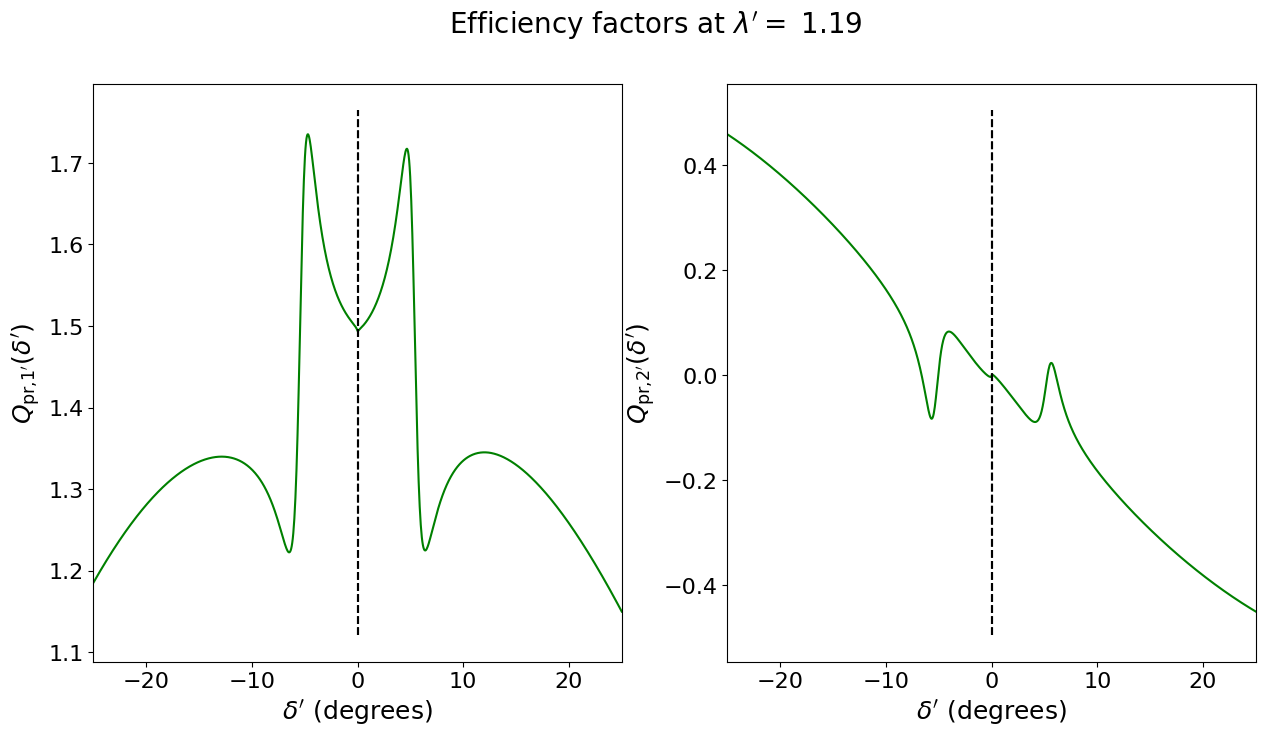

In [ ]:
def Q(angle, r, t):
    def beta_m(m):
        test=(np.sin(angle)+m*wavelength/grating_pitch)
        if abs(test)>=1:
            delta_m="no_diffraction_order"
        else:
            delta_m=np.arcsin(test)
        return delta_m
    Q1=0
    Q2=0
    M=[-1,0,1]
    for m in range(len(M)):
        delta_m=beta_m(M[m])
        if isinstance(delta_m,str):
            Q1=Q1+0
            Q2=Q2+0
        else:
            Q1=Q1+ r[m]*(1+np.cos(angle+delta_m))+t[m]*(1-np.cos(delta_m-angle))
            Q2=Q2+ r[m]*np.sin(angle+delta_m)+t[m]*np.sin(delta_m-angle)
    Q1=np.cos(angle)*Q1
    Q2=-np.cos(angle)*Q2
    return Q1,Q2

import matplotlib.pyplot as plt
wavelength = 1. / D1_ND(16.869/100)
k = 1000
angles = (np.pi/180)*np.linspace(-25,25,k)

Q1_array = []
Q2_array = []

Rs = [] 
Ts = [] 

grating.wavelength = wavelength
for i in range(k):
    angle = angles[i]
    grating.angle = angle
    r, t = grating.eff()

    Rs.append(r)
    Ts.append(t)

    Q1, Q2 = Q(angle, r, t)
    Q1_array.append(Q1)
    Q2_array.append(Q2)

Q1_array = np.array(Q1_array)
Q2_array = np.array(Q2_array)
Rs = np.array(Rs)
Ts = np.array(Ts)

#### Plotting
## Finding cutoffs
cutoff = np.arcsin( 1 - wavelength / grating_pitch) * (180/np.pi)
cutoff2_test = 1 - 2* wavelength / grating_pitch
order_2 = False
if np.abs(cutoff2_test)<1:
    order_2 = True
    cutoff2 = np.arcsin(cutoff2_test) * (180/np.pi)


##############################
## Reflection/transmission
fig1, (ax, ax_) = plt.subplots(nrows=1, ncols=2, sharey=True)
ax.plot((180/np.pi)*angles, Rs[:,0], color="red",                       label="$r_{-1}$")
ax_.plot((180/np.pi)*angles, Ts[:,0], color="red", linestyle="dotted",  label="$t_{-1}$")
ax.plot((180/np.pi)*angles, Rs[:,1], color="grey",                      label="$r_{0}$")
ax_.plot((180/np.pi)*angles, Ts[:,1], color="grey", linestyle="dotted", label="$t_{0}$")
ax.plot((180/np.pi)*angles, Rs[:,2], color="blue",                      label="$r_{1}$")
ax_.plot((180/np.pi)*angles, Ts[:,2], color="blue", linestyle="dotted", label="$t_{1}$")

ax.legend()
ax_.legend()

ax_ylims = ax.get_ylim()
ax__ylims = ax_.get_ylim()
ax.set_xlim(xmin=(180/np.pi)*angles[0], xmax=(180/np.pi)*angles[-1])
ax_.set_xlim(xmin=(180/np.pi)*angles[0], xmax=(180/np.pi)*angles[-1])

ax.vlines(x= cutoff, ymin=ax_ylims[0], ymax=ax_ylims[1], color='black', linestyle = 'dashed')
ax.vlines(x=-cutoff, ymin=ax_ylims[0], ymax=ax_ylims[1], color='black', linestyle = 'dashed')
ax_.vlines(x= cutoff, ymin=ax__ylims[0], ymax=ax__ylims[1], color='black', linestyle = 'dashed')
ax_.vlines(x=-cutoff, ymin=ax__ylims[0], ymax=ax__ylims[1], color='black', linestyle = 'dashed')
if order_2:
    ax.vlines(x= cutoff2, ymin=ax_ylims[0], ymax=ax_ylims[1], color='black', linestyle = 'dashed')
    ax.vlines(x=-cutoff2, ymin=ax_ylims[0], ymax=ax_ylims[1], color='black', linestyle = 'dashed')
    ax_.vlines(x= cutoff2, ymin=ax__ylims[0], ymax=ax__ylims[1], color='black', linestyle = 'dashed')
    ax_.vlines(x=-cutoff2, ymin=ax__ylims[0], ymax=ax__ylims[1], color='black', linestyle = 'dashed')

ax.set_xlabel("$\delta'$ (degrees)")
ax_.set_xlabel("$\delta'$ (degrees)")
fig1.suptitle(rf"Reflection/transmission at $\lambda'=$ {wavelength:.2f}")

##############################
## Sum
fig, ax1 = plt.subplots(nrows=1, ncols=1)
ax1.plot((180/np.pi)*angles, Rs[:,0]+Rs[:,1]+Rs[:,2] + Ts[:,0]+Ts[:,1]+Ts[:,2])
ax_ylims = ax1.get_ylim()
ax1.vlines(x= cutoff, ymin=ax_ylims[0], ymax=ax_ylims[1], color='black', linestyle = 'dashed')
ax1.vlines(x=-cutoff, ymin=ax_ylims[0], ymax=ax_ylims[1], color='black', linestyle = 'dashed')
if order_2:
    ax1.vlines(x= cutoff2, ymin=ax_ylims[0], ymax=ax_ylims[1], color='black', linestyle = 'dashed')
    ax1.vlines(x=-cutoff2, ymin=ax_ylims[0], ymax=ax_ylims[1], color='black', linestyle = 'dashed')
ax1.set_xlabel("$\delta'$ (degrees)")
fig.suptitle(rf"Sum of reflection/transmission at $\lambda'=$ {wavelength:.2f}")

##############################
## Efficiency factors
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.plot((180/np.pi)*angles, Q1_array,       color="green",    label="GRCWA")
ax2.plot((180/np.pi)*angles, Q2_array,       color="green",    label="GRCWA")
ax1.set_xlim(xmin=(180/np.pi)*angles[0], xmax=(180/np.pi)*angles[-1])
ax2.set_xlim(xmin=(180/np.pi)*angles[0], xmax=(180/np.pi)*angles[-1])

ax1_ylims = ax1.get_ylim()
ax2_ylims = ax2.get_ylim()

ax1.vlines(x= cutoff, ymin=ax1_ylims[0], ymax=ax1_ylims[1], color='black', linestyle = 'dashed')
ax1.vlines(x=-cutoff, ymin=ax1_ylims[0], ymax=ax1_ylims[1], color='black', linestyle = 'dashed')
ax2.vlines(x= cutoff, ymin=ax2_ylims[0], ymax=ax2_ylims[1], color='black', linestyle = 'dashed')
ax2.vlines(x=-cutoff, ymin=ax2_ylims[0], ymax=ax2_ylims[1], color='black', linestyle = 'dashed')
if order_2:
    ax1.vlines(x= cutoff2, ymin=ax1_ylims[0], ymax=ax1_ylims[1], color='black', linestyle = 'dashed')
    ax1.vlines(x=-cutoff2, ymin=ax1_ylims[0], ymax=ax1_ylims[1], color='black', linestyle = 'dashed')
    ax2.vlines(x= cutoff2, ymin=ax2_ylims[0], ymax=ax2_ylims[1], color='black', linestyle = 'dashed')
    ax2.vlines(x=-cutoff2, ymin=ax2_ylims[0], ymax=ax2_ylims[1], color='black', linestyle = 'dashed')

ax1.set_xlabel("$\delta'$ (degrees)")
ax1.set_ylabel("$Q_{\\text{pr,1}'} (\delta')$")
ax2.set_xlabel("$\delta'$ (degrees)")
ax2.set_ylabel("$Q_{\\text{pr,2}'} (\delta')$")

fig.suptitle(rf"Efficiency factors at $\lambda'=$ {wavelength:.2f}")
